<img src='resources/dl.jpg'>

# Sentiment Analysis with Keras

### Keras

Keras is a deep learning library that focuses on providing a high level neural network API that comes with the best practicises included. It's ideal for beginners until you need more advanced features or know why or why you wont need the various best practices.

### Sentiment Analysis

In [1]:
!apt-get install graphviz
!pip install graphviz pydot

E: Could not open lock file /var/lib/dpkg/lock - open (13: Permission denied)
E: Unable to lock the administration directory (/var/lib/dpkg/), are you root?


In [1]:
from IPython.display import SVG

import numpy as np
import string

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Activation, Flatten, Dense, Dropout, Embedding, LSTM, GRU, Bidirectional, Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
from keras.utils.vis_utils import model_to_dot

/home/eavi/leon/keras_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## IMDB Movie reviews sentiment classification

Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). 

For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words", by using the ```num_words``` argument.

As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

#### Special Tokens:

```
0: <PAD>
1: <START>
2: <UNKNOWN>
```

In [2]:
number_of_words_tokenised = 20000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=number_of_words_tokenised,
                                                      index_from=3)

17465344/17464789 [==============================] - 2s 0us/step


In [4]:
print(len(x_train), 'train reviews')
print(len(x_test), 'test reviews')

25000 train reviews
25000 test reviews


We can see that we have 25000 arbitrarily lengthed sentances

In [5]:
x_train.shape, len(x_train[0]), len(x_train[1])

((25000,), 218, 189)

In [6]:
print('Pad sequences (samples x time)')
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 100
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)


## Understanding the dataset

Here we go from sequences of embedding indices to sentances and back again.

In [7]:
def convert_sentance_to_indices(sentance, 
                                max_sentance_length,
                                word_to_index_dict, 
                                start_index=1, 
                                unknown_index=2,
                                pad_index=0,
                                remove_punctuation=False):
    
    if remove_punctuation:
        strip_table = str.maketrans({key: None for key in string.punctuation})
        sentance = sentance.translate(strip_table)
        
    indices = [start_index]
    for word_count, word in enumerate(sentance.split()):
        
        if word_count >= max_sentance_length:
            break
            
        try:
            index = word_to_index_dict[word]
        except:
            index = unknown_index
        indices.append(index)
        
    while len(indices) < max_sentance_length:
        indices = [pad_index] + indices
    
    return indices


def convert_indices_to_sentance(indices, index_to_word_dict):
    words = [index_to_word_dict[index] for index in indices]
    return " ".join(words)

In [8]:
word_to_index_dict = imdb.get_word_index()
word_to_index_dict = {key: (value + 3) for key, value in word_to_index_dict.items()}
word_to_index_dict['<START>'] = 1
word_to_index_dict['<PAD>'] = 0
word_to_index_dict['<UNKNOWN>'] = 2

index_to_word_dict = {value: key for key, value in word_to_index_dict.items()}

1646592/1641221 [==============================] - 1s 1us/step


In [13]:
index = 0

sentance = convert_indices_to_sentance(x_test[index], index_to_word_dict)
label = y_test[index]

print("\n** What the neural network will see: **")
print(x_test[index])

print("\n** What we humans like to see: **")
print(sentance)

print("\n** What we want the neural network to predict: **")
print(label)

print("\n** The label is: **")
print("Positive" if label == 1 else "Negative")


** What the neural network will see: **
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     1   591   202    14
    31     6   717    10    10 18142 10698     5     4   360     7     4
   177  5760   394   354     4   123     9  1035  1035  1035    10    10
    13    92   124    89   488  7944   100    28  1668    14    31    23
    27  7479    29   220   468     8   124    14   286   170     8   157
    46     5    27   239    16   179 15387    38    32    25  7944   451
   202    14     6   717]

** What we humans like to see: **
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show 

## Making models is like playing with Lego


Keras allows us to play with neural architecture lego blocks and stack things together in weird and wonderful ways. For now don't get bogged down in the theory of what works and doesn't work. Just be aware of what the shape each block needs as an input, and what the shape each block will output.

<img src="resources/tower.jpg" width="400">

Below are a bunch of models that you can try and extend, aswell as a blank function you could fill in with your own creation! [Feel free to browse the reference for available neural lego blocks to use.](https://keras.io/layers/about-keras-layers/)

In [14]:
def mlp(number_of_words_tokenised, sizes, keep_prob=0.1):
    
    model = Sequential()

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions.
    model.add(Embedding(number_of_words_tokenised, 50, input_length=maxlen))
    model.add(Dropout(keep_prob))
    model.add(Flatten())

    # For each size in the hidden sizes, add a vanilla hidden layer:
    for size in sizes:
        model.add(Dense(size))
        model.add(Dropout(keep_prob))
        model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model


def rnn(number_of_words_tokenised, rnn_type='lstm', hidden_size=64, keep_prob=0.5):
    
    model = Sequential()
    model.add(Embedding(number_of_words_tokenised, 128))
    
    if rnn_type is 'lstm':
        rnn_cell = LSTM(hidden_size, dropout=keep_prob, recurrent_dropout=keep_prob)
    else:
        rnn_cell = GRU(hidden_size, dropout=keep_prob, recurrent_dropout=keep_prob)
        
    model.add(rnn_cell)
    model.add(Dense(1, activation='sigmoid'))
    
    return model


def bidirectional_rnn(number_of_words_tokenised, rnn_type='lstm', hidden_size=64, keep_prob=0.5):
    
    model = Sequential()
    
    model.add(Embedding(number_of_words_tokenised, 128, input_length=maxlen))
    
    rnn_cell = LSTM(hidden_size) if rnn_type is 'lstm' else GRU(hidden_size)
    
    model.add(Bidirectional(rnn_cell))
    model.add(Dropout(keep_prob))
    model.add(Dense(1, activation='sigmoid'))
    
    return model


def convolutional(number_of_words_tokenised, filters=250, kernel_size=3, hidden_dims=250, keep_prob=0.2):
    
    model = Sequential()

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(number_of_words_tokenised, 128, input_length=maxlen))
    model.add(Dropout(keep_prob))

    # we add a Convolution1D, which will learn filters
    # word group filters of size filter_length:
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    # we use max pooling:
    model.add(GlobalMaxPooling1D())

    # We add a vanilla hidden layer:
    model.add(Dense(hidden_dims))
    model.add(Dropout(keep_prob))
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model


def my_model(number_of_words_tokenised):
    
    model = Sequential()
    
    # ... Insert code here ...
    # Ensure that the model ends with a single
    # sigmoidal unit.
    
    return model

## Construct desired model and view structure

We choose the function we would like to construct our model and we then run it through a few helper functions to visualise the graph.

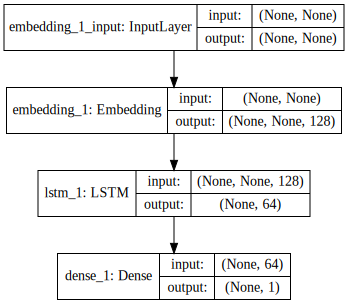

In [15]:
# model = mlp(number_of_words_tokenised, sizes=[1000, 50, 10])
model = rnn(number_of_words_tokenised)
# model = bidirectional_rnn(number_of_words_tokenised)
# model = convolutional(number_of_words_tokenised)
# model = my_model(number_of_words_tokenised)

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Training

Binary Cross entropy is defined as:
$$-{(y\log(p) + (1 - y)\log(1 - p))}$$

In [16]:
# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [17]:
batch_size = 256
epochs = 4

model.fit(x_train, 
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=[x_test, y_test])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4


ResourceExhaustedError: OOM when allocating tensor with shape[256,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: lstm_1/while/mul_1 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](lstm_1/while/TensorArrayReadV3, lstm_1/while/mul_1/Enter)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss/mul/_115 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2456_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'lstm_1/while/mul_1', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-0ac6d69b0eec>", line 2, in <module>
    model = rnn(number_of_words_tokenised)
  File "<ipython-input-14-d9341a11e234>", line 34, in rnn
    model.add(rnn_cell)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/keras/models.py", line 492, in add
    output_tensor = layer(self.outputs[0])
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/keras/layers/recurrent.py", line 499, in __call__
    return super(RNN, self).__call__(inputs, **kwargs)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/keras/engine/topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/keras/layers/recurrent.py", line 2063, in call
    initial_state=initial_state)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/keras/layers/recurrent.py", line 608, in call
    input_length=timesteps)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2764, in rnn
    swap_memory=True)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2934, in while_loop
    result = loop_context.BuildLoop(cond, body, loop_vars, shape_invariants)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2720, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2662, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2750, in _step
    tuple(constants))
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/keras/layers/recurrent.py", line 599, in step
    return self.cell.call(inputs, states, **kwargs)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/keras/layers/recurrent.py", line 1824, in call
    inputs_f = inputs * dp_mask[1]
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 907, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1131, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2798, in _mul
    "Mul", x=x, y=y, name=name)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/home/eavi/leon/keras_env/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[256,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: lstm_1/while/mul_1 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](lstm_1/while/TensorArrayReadV3, lstm_1/while/mul_1/Enter)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss/mul/_115 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2456_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



## Using the model!

The first step is to create a bunch of sentances that are either positive or negative. The model will then predict this. Because the model ends with a single sigmoidal neuron, which means the value it will output will be squashed between zero and one, we can simply binarise the value by checking if it is greater than 0.5.

In [79]:
test_sentances = []

test_sentances.append("good movie")
test_sentances.append("bad movie")
test_sentances.append("I hate big corporations, especially tech companies like facebook.")
test_sentances.append("I love being a contrarian.")
test_sentances.append("Argh! Fuck this!")
test_sentances.append("To be honest this was a fun thing.")
test_sentances.append("Just tried watching Modern Family - written by a moron, really boring. Writer has the mind of a very dumb and backward child.")
test_sentances.append("I look very much forward to showing my financials, because they are huge.")

for i, test_sentance in enumerate(test_sentances):
    
    test_sentance_indices = convert_sentance_to_indices(test_sentance, 
                                                        maxlen, 
                                                        word_to_index_dict)
    test_sentance_indices = np.array(test_sentance_indices).reshape((1, -1))

    prediction = model.predict(x=test_sentance_indices)[0]

    if prediction < 0.5:
        print("{}. '{}' was a negative sentance".format(i, test_sentance))
    else:
        print("{}. '{}' was a positive sentance".format(i, test_sentance))

0. 'good movie' was a positive sentance
1. 'bad movie' was a negative sentance
2. 'I hate big corporations, especially tech companies like facebook.' was a negative sentance
3. 'I love being a contrarian.' was a positive sentance
4. 'Argh! Fuck this!' was a positive sentance
5. 'To be honest this was a fun thing.' was a positive sentance
6. 'Just tried watching Modern Family - written by a moron, really boring. Writer has the mind of a very dumb and backward child.' was a negative sentance
7. 'I look very much forward to showing my financials, because they are huge.' was a positive sentance
